# Preperation

## Import Libraries and Data

In [124]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
wells4 = pd.read_csv('data/wells4.csv', index_col = 0)

## Feature Engineering

#### Create well_age feature

In [3]:
wells4['well_age'] = wells4.year_recorded - wells4.construction_year

In [4]:
print(wells4.well_age.describe())
print(wells4.well_age.loc[lambda x : x<0])

count    59400.000000
mean        15.042374
std         10.100175
min         -7.000000
25%          8.000000
50%         14.000000
75%         16.000000
max         53.000000
Name: well_age, dtype: float64
8729    -4
10441   -2
13366   -7
23373   -5
27501   -5
32619   -1
33942   -3
39559   -5
48555   -4
Name: well_age, dtype: int64


Obviously it is not possible to have a well with a negative age.  Likely erroneous values in the original dataset for construction_year or date_recorded.  Since they are few in number, I will set the negative values to null and use a SimpleImputer in the Column Transformer.

In [5]:
wells4.loc[wells4.well_age < 0, "well_age"] = np.nan

#### Convert Appropriate Numeric Columns to Categorical

In [6]:
wells4[['construction_year', 'year_recorded']] = wells4[['construction_year', 'year_recorded']].astype('str')

### Create Train Test Split

In [7]:
X = wells4.drop(['status_group'], axis=1)
y = wells4['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52)

### Subpipes & Column Transformer

In [8]:
# Create pipelines to properly scale / encode different data types for use in column transformer

subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler())
    ])

subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

#subpipe_ord = Pipeline(steps=[('ord', OrdinalEncoder())])

In [9]:
# Create list of features for each subpipe
cat_feat = X_train.select_dtypes(include=['object']).columns
num_feat = X_train.select_dtypes(include=['float', 'int64']).columns


In [10]:
ct = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, num_feat),
    ('subpipe_cat', subpipe_cat, cat_feat),
    #('subpipe_ord', subpipe_ord, ord_feat)
    ])

# Modeling
Since water is so vital, the Tanzanian government wants to focus on identifying wells that need work.  The modeling process will aim to minimize the number of wells that are predicted to be functional, but actually need work (false positives).  Therefore precision will be used as the primary scoring metric with secondary consideration for accuracy.  

### Dummy Classifier

In [11]:
# Using a pipeline to maintain consistency with later models, dummy strategy of most frequent to establlish a baseline

dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dum', DummyClassifier(strategy='most_frequent', random_state=52))
])

In [12]:
dummy_pipe.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [13]:
precision_score(y_train, dummy_pipe.predict(X_train))

0.54341189674523

Unsurprisingly, the precision score for the dummy classifier is not very good.

### First Simple Model

In [14]:
dct_pipe = Pipeline(steps=[
    ('ct',ct),
    ('dct', DecisionTreeClassifier(random_state=52))
])

In [15]:
dct_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [16]:
precision_score(y_train, dct_pipe.predict(X_train))

0.9946365211651126

In [17]:
cross_val_score(dct_pipe, X_train, y_train, scoring='precision', error_score='raise')

array([0.79621543, 0.78748718, 0.78698953, 0.79368729, 0.79621451])

#### Evaluation
The untuned decision tree model performs significantly better than the baseline, but not particularly great precision and significantly overfit. FSM was useful in identifying that some categoricals were causing it to run very slowly. Eliminated some features with further EDA and reran FSM.

### Second Model

In [18]:
lr_pipe = Pipeline(steps=[
    ('ct',ct),
    ('lr', LogisticRegression(random_state=52, max_iter=1000))
    ])

In [19]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [20]:
# defaults and max iter=1000
cross_val_score(lr_pipe, X_train, y_train, scoring='precision', error_score='raise')

array([0.7231178 , 0.71530683, 0.71997912, 0.72472893, 0.72505699])

#### GridSearch 
Untuned LogReg underperformed it's DCT counterpart, trying Gridsearch to tune LogReg hyperparameters

In [21]:
params = {}
params['lr__solver'] = ['newton-cg', 'lbfgs', 'saga']
params['lr__C'] = [.25, .5, 1, 2]

In [22]:
gs = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [23]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [24]:
gs.cv_results_['mean_test_score']

array([0.72124999, 0.72124027, 0.72128096, 0.72126113, 0.72130581,
       0.72130621, 0.72166316, 0.72163793, 0.72163713, 0.72155984,
       0.72147398, 0.72152267])

In [25]:
gs.best_params_

{'lr__C': 1, 'lr__solver': 'newton-cg'}

#### LR Follow Up GridsearchCV
Initial tuning had limited success.  Will try taking the best params and tweaking other hyperparameters

In [29]:
params = {}
params['lr__solver'] = ['newton-cg']
params['lr__C'] = [1, 2, 10]
params['lr__penalty'] = ['l2', 'none']

In [30]:
gs1 = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [31]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [32]:
gs1.cv_results_['mean_test_score']

array([0.72166316, 0.72166589, 0.72155984, 0.72166589, 0.72173604,
       0.72166589])

In [33]:
gs1.best_params_

{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}

#### Final attempt at tuning LR

In [34]:
params = {}
params['lr__solver'] = ['newton-cg', 'liblinear']
params['lr__C'] = [1, 10, 100]
params['lr__penalty'] = ['l2']

In [35]:
gs1_2 = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')
gs1_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [36]:
gs1_2.best_params_

{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}

In [37]:
gs1_2.cv_results_['mean_test_score']

array([0.72166316, 0.72163753, 0.72173604, 0.72173014, 0.72172148,
       0.72165185])

#### No Improvement
With virtually no improvement after three rounds of parameter tuning, LogReg does not appear to be a good fit.

### Model 3 A Tuned DTC?

In [40]:
params = {}
params['dct__criterion'] = ['gini', 'entropy']
params['dct__max_depth'] = [5, 10, 25]

gs3 = GridSearchCV(estimator=dct_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [41]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [42]:
gs3.cv_results_['mean_test_score']

array([0.69116939, 0.71062492, 0.78417855, 0.68819554, 0.70445509,
       0.78177644])

In [43]:
gs3.best_params_

{'dct__criterion': 'gini', 'dct__max_depth': 25}

#### Second tune
Scores were actually down slightly from the untuned DCT and the max_depth choose the highest value, so I will try rerunning with higher values for that param

In [44]:
params = {}
params['dct__criterion'] = ['gini', 'entropy']
params['dct__max_depth'] = [25, 52, 100]

gs3_2 = GridSearchCV(estimator=dct_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [45]:
gs3_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [46]:
gs3_2.cv_results_['mean_test_score']

array([0.78417855, 0.79184378, 0.79211879, 0.78177644, 0.79031866,
       0.79004281])

In [47]:
gs3_2.best_params_

{'dct__criterion': 'gini', 'dct__max_depth': 100}

#### Third Tune
The best DTC params so far are gini and max_depth 100.  Will  try a higher max_depth and try other params

In [58]:
params = {}
params['dct__criterion'] = ['gini']
params['dct__max_depth'] = [100, 200, 500]
params['dct__min_samples_leaf'] = [1, 3, 5, 10]
print(params)

gs3_3 = GridSearchCV(estimator=dct_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='precision')

{'dct__criterion': ['gini'], 'dct__max_depth': [100, 200, 500], 'dct__min_samples_leaf': [1, 3, 5, 10]}


In [59]:
gs3_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [60]:
gs3_3.cv_results_['mean_test_score']

array([0.79211879, 0.7968784 , 0.79537862, 0.79079924, 0.79211879,
       0.7968784 , 0.79537862, 0.79079924, 0.79211879, 0.7968784 ,
       0.79537862, 0.79079924])

In [61]:
gs3_3.best_params_

{'dct__criterion': 'gini', 'dct__max_depth': 100, 'dct__min_samples_leaf': 3}

#### Evaluation
Unfortunately, tuning the DTC in a precision score that was not significantly different from the untuned DTC.

### Model 4: Trying Different estimators & the Stacking Ensemble 

In [78]:
stc = StackingClassifier(n_jobs=-2, estimators=[
    ('knn', KNeighborsClassifier()),
    ('rfc', RandomForestClassifier(random_state=52)),
    ('gbc', GradientBoostingClassifier(random_state=52))
    ])

In [79]:
stc_pipe = Pipeline([('ct',ct), ('stc', stc)])

In [80]:
stc_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [81]:
stc_pipe.score(X_train, y_train)

0.9723007856341189

In [82]:
precision_score(y_train, stc_pipe.predict(X_train))

0.9668387044336977

In [83]:
cross_val_score(stc_pipe, X_train, y_train, scoring='precision', error_score='raise')

array([0.80503022, 0.80276817, 0.80022896, 0.80619707, 0.80736268])

#### Eval
A modest improvement over the tuned DTC, however it is quite over fit.  Will try to reduce overfit with hyperparameter tuning.

In [84]:
params = {}
params['stc__knn__n_neighbors'] = [5,10, 50]
params['stc__rfc__criterion'] = ['gini','entropy']
params['stc__rfc__min_samples_leaf'] = [1,5,10]


In [85]:
gs4 = GridSearchCV(estimator=stc_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [86]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [87]:
gs4.cv_results_['mean_test_score']

array([0.80431742, 0.79544407, 0.79253911, 0.80366161, 0.79601201,
       0.79328545, 0.80567458, 0.79358936, 0.78819665, 0.80490766,
       0.79405957, 0.78905308, 0.80656982, 0.79288047, 0.78373936,
       0.80575551, 0.79365071, 0.78408109])

In [88]:
gs4.best_params_

{'stc__knn__n_neighbors': 50,
 'stc__rfc__criterion': 'gini',
 'stc__rfc__min_samples_leaf': 1}

#### Second Tune Focused on n_neighbors

In [89]:
params = {}
params['stc__knn__n_neighbors'] = [50, 100, 1000]
params['stc__rfc__criterion'] = ['gini']

In [90]:
gs4_2 = GridSearchCV(estimator=stc_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [91]:
gs4_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [92]:
gs4_2.cv_results_['mean_test_score']

array([0.80656982, 0.80586253, 0.80486234])

In [93]:
gs4.best_params_

{'stc__knn__n_neighbors': 50,
 'stc__rfc__criterion': 'gini',
 'stc__rfc__min_samples_leaf': 1}

### Model 5: Reducing complexity by using only RFC

In [94]:
rfc_pipe = Pipeline(steps=[
    ('ct',ct),
    ('rfc', RandomForestClassifier(random_state=52))
    ])

In [95]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [96]:
cross_val_score(rfc_pipe, X_train, y_train, scoring='precision')

array([0.80846854, 0.80968183, 0.80745098, 0.8111639 , 0.80912698])

#### RFC Tuning 1
Untuned RFC produced the best precision yet, but still very overfit.

In [97]:
params = {}

params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__max_depth'] = [25, 50, 100, 250]

In [98]:
gs5 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [99]:
gs5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [100]:
gs5.cv_results_['mean_test_score']

array([0.79777879, 0.80901275, 0.80917845, 0.80917845, 0.7947248 ,
       0.80972191, 0.80998732, 0.80998732])

In [102]:
gs5.best_params_

{'rfc__criterion': 'entropy', 'rfc__max_depth': 100}

#### Second Tune

In [103]:
params = {}

params['rfc__n_estimators'] = [100, 200, 500]
params['rfc__max_depth'] = [75, 100, 125]

In [104]:
gs5_2 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [105]:
gs5_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [106]:
gs5_2.cv_results_['mean_test_score']

array([0.80917845, 0.80921478, 0.80971885, 0.80917845, 0.80921478,
       0.80972635, 0.80917845, 0.80921478, 0.80972635])

In [107]:
gs5_2.best_params_

{'rfc__max_depth': 100, 'rfc__n_estimators': 500}

#### More Estimators -> Slightly less overfit

In [108]:
params = {}

params['rfc__n_estimators'] = [500, 1000]
params['rfc__max_depth'] = [100]
params['rfc__min_samples_split'] = [5, 10, 25]

In [109]:
gs5_3 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [110]:
gs5_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [111]:
gs5_3.cv_results_['mean_test_score']

array([0.80775745, 0.80837031, 0.80368318, 0.80372582, 0.79164855,
       0.79185335])

In [112]:
gs5_3.best_params_

{'rfc__max_depth': 100, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 1000}

#### Final Tune Attempt

In [113]:
params = {}

params['rfc__n_estimators'] = [1000, 2000]
params['rfc__max_depth'] = [100]
params['rfc__min_samples_split'] = [3, 5, 7]

In [114]:
gs5_4 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='precision')

In [115]:
gs5_4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [116]:
gs5_4.cv_results_['mean_test_score']

array([0.80973109, 0.80908579, 0.80837031, 0.80834725, 0.80638757,
       0.80636317])

In [117]:
gs5_4.best_params_

{'rfc__max_depth': 100, 'rfc__min_samples_split': 3, 'rfc__n_estimators': 1000}

## Final Model

In [119]:
final_pipe = Pipeline(steps=[
    ('ct',ct),
    ('rfc', RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=52))
    ])

In [120]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [121]:
# Forgot to include min_samples_split=3 in params, decided to test that change and it increased precision
cross_val_score(final_pipe, X_train, y_train, scoring='precision')

array([0.80793401, 0.81146098, 0.80725228, 0.8124385 , 0.81095511])

In [125]:
print(f"""
    Final Test Accuracy: {accuracy_score(y_test, final_pipe.predict(X_test))}
    Final Test Precision: {precision_score(y_test, final_pipe.predict(X_test))}
""")


    Final Test Accuracy: 0.8114478114478114
    Final Test Precision: 0.8060867537313433



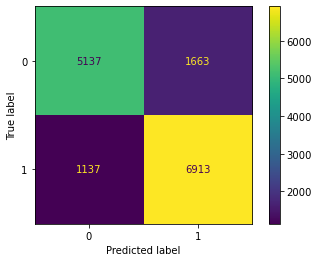

In [126]:
plot_confusion_matrix(final_pipe, X_test, y_test);

#### Evaluation
The final model can predict if a well is functioning and not in need of repair with 80.6% precision and 81.1% accuracy. Overall, the final model solidly outperformed the baseline model's precision of 57% and was an incremental improvement over the FSM. 

### Mapping the Final Model